In [1]:
pip install paddleocr paddlepaddle

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
from paddleocr import PaddleOCR
import cv2
import re
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [15]:

# Function to calculate bounding box area
def calculate_area(points):
    x_coords = [point[0] for point in points]
    y_coords = [point[1] for point in points]
    width = max(x_coords) - min(x_coords)
    height = max(y_coords) - min(y_coords)
    return width * height

# Function to extract the average color within a bounding box
def extract_text_color(image, box):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    pts = np.array([box], dtype=np.int32)
    cv2.fillPoly(mask, pts, 255)
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    colors = cv2.mean(image, mask=mask)[:3]
    return colors  # returns (B, G, R) tuple



In [16]:
# Function to display image using matplotlib
def display_image_with_matplotlib(image, title="Image"):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')  # Hide axis
    plt.show()

In [17]:
# Function to preprocess the image
def preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path)
    
    # Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    display_image_with_matplotlib(gray_img, "Grayscale Image")

    # Noise reduction using Gaussian Blur
    blurred_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
    display_image_with_matplotlib(blurred_img, "Blurred Image")

    # Histogram equalization to enhance contrast
    equalized_img = cv2.equalizeHist(blurred_img)
    display_image_with_matplotlib(equalized_img, "Histogram Equalization")

    # # Adaptive Thresholding
    # adaptive_thresh = cv2.adaptiveThreshold(equalized_img, 255, 
    #                                         cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    #                                         cv2.THRESH_BINARY, 11, 2)
    # display_image_with_matplotlib(adaptive_thresh, "Adaptive Thresholding")

    # # Morphological operation to close small gaps in text
    # kernel = np.ones((3, 3), np.uint8)
    # morph_img = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel)
    # display_image_with_matplotlib(morph_img, "Morphological Transformation")

    # # Denoising
    # denoised_img = cv2.fastNlMeansDenoising(morph_img, None, 30, 7, 21)
    # display_image_with_matplotlib(denoised_img, "Denoised Image")

    return img, equalized_img  # Return original and preprocessed image


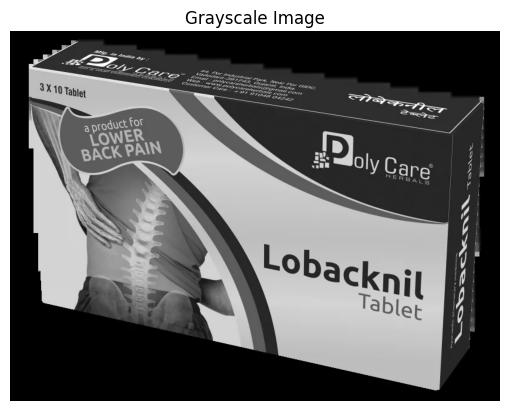

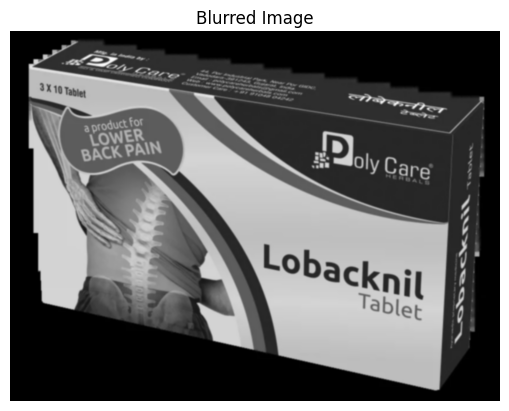

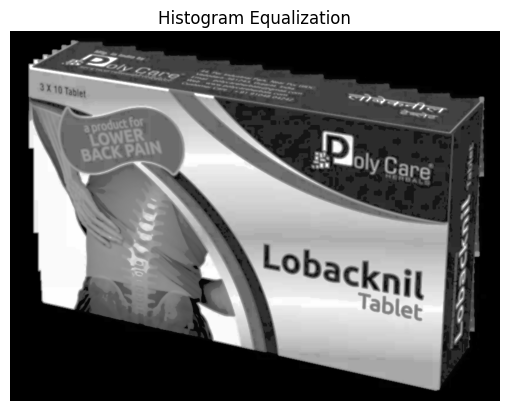

[2024/09/19 15:17:51] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.08921313285827637
[2024/09/19 15:17:51] ppocr DEBUG: cls num  : 9, elapsed : 0.01916956901550293
[2024/09/19 15:17:52] ppocr DEBUG: rec_res num  : 9, elapsed : 0.2866826057434082
Recognized Text: 3 X10 Tablet
Medicine Name(s):  X,  Tablet
Recognized Text: aproduct.for
Medicine Name(s): aproduct, for
Recognized Text: LOWER
Medicine Name(s): LOWER
Recognized Text: P
Medicine Name(s): P
Recognized Text: BACK PAIN
Medicine Name(s): BACK PAIN
Recognized Text: olyCare
Medicine Name(s): olyCare
Recognized Text: Lobacknil
Medicine Name(s): Lobacknil
Recognized Text: S
Medicine Name(s): S
Recognized Text: Tablet
Medicine Name(s): Tablet


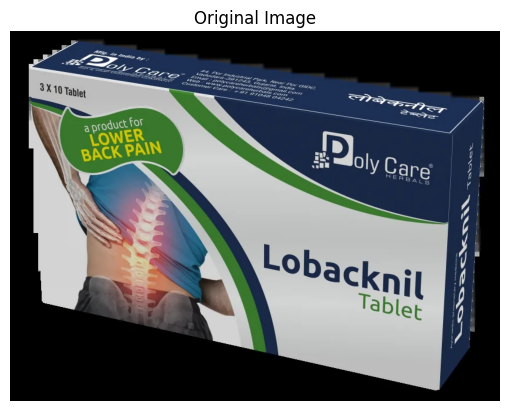

In [32]:
def process_image_for_ocr(image_path):
    try:
        original_image, preprocessed_image = preprocess_image(image_path)
    except FileNotFoundError as e:
        print(e)
        return
    
    # Perform OCR on the preprocessed image
    result = ocr.ocr(preprocessed_image, cls=True)

    if result is None:
        print("No text detected.")
        return

    # Analyze each text box
    for res in result:
        for line in res:
            box = line[0]  # Bounding box coordinates
            text = line[1][0].strip()  # Extract recognized text
            
            # Extract medicine information
            names, dosages = extract_medicine_info(text)

            # Output recognized text
            if names or dosages:
                print(f"Recognized Text: {text}")
                if names:
                    print(f"Medicine Name(s): {', '.join(names)}")
                if dosages:
                    print(f"Dosage(s): {', '.join([d[0] for d in dosages])}")

    # Display original image using matplotlib
    display_image_with_matplotlib(original_image, "Original Image")

# Test image path
image_path = '6.webp'  # Replace with your image path
process_image_for_ocr(image_path)


In [70]:
import re

# List of common irrelevant words and suffixes/prefixes
COMMON_WORDS = ["Tablet", "X", "for", "LOWER", "BACK", "PAIN", "mg", "capsule", "syrup", "cream", "injection", "ml", "ointment"]

# Additional irrelevant symbols and characters to remove
SPECIAL_CHARACTERS = r'[^a-zA-Z\s]'

# List of prefixes and suffixes that usually accompany medicine names
MEDICINE_KEYWORDS = ["mg", "capsule", "tablet", "injection", "cream", "ointment", "syrup", "solution", "dose"]

def clean_text(text):
    # Remove special characters, extra spaces, and make the text consistent
    text = re.sub(SPECIAL_CHARACTERS, '', text)
    return text.strip()

def extract_medicine_name(text):
    # Clean the text to remove special characters
    text = clean_text(text)

    # Split text into words
    words = text.split()

    # Filter out common irrelevant words
    filtered_words = [word for word in words if word.lower() not in [w.lower() for w in COMMON_WORDS]]

    # Consider multi-word medicine names (e.g., "Paracetamol 500mg")
    possible_medicine_name = []
    for i, word in enumerate(filtered_words):
        if word[0].isupper():  # Check if the word starts with a capital letter
            # Check if the next word is a possible medicine-related term (like "mg", "capsule", etc.)
            if i + 1 < len(filtered_words) and filtered_words[i + 1].lower() in MEDICINE_KEYWORDS:
                possible_medicine_name.append(f"{word} {filtered_words[i + 1]}")
            else:
                possible_medicine_name.append(word)

    # Return the longest or most reasonable name (assuming it's the medicine)
    return ' '.join(possible_medicine_name) if possible_medicine_name else None

def process_image_for_ocr(image_path):
    try:
        original_image, preprocessed_image = preprocess_image(image_path)
    except FileNotFoundError as e:
        print(e)
        return
    
    # Perform OCR on the preprocessed image
    result = ocr.ocr(preprocessed_image, cls=True)

    if result is None:
        print("No text detected.")
        return

    # Analyze each text box
    for res in result:
        for line in res:
            text = line[1][0].strip()  # Extract recognized text
            
            # Extract the most likely medicine name
            medicine_name = extract_medicine_name(text)

            # Output recognized text and filtered medicine name
            if medicine_name:
                print(f"Recognized Text: {text}")
                print(f"Medicine Name: {medicine_name}")

    # Display original image using matplotlib
    display_image_with_matplotlib(original_image, "Original Image")

# Test the improved extraction method
process_image_for_ocr(r'C:\Users\Dell\MedicineOCR\4.webp')


[2024/09/20 12:50:23] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.009718179702758789
[2024/09/20 12:50:23] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/09/20 12:50:23] ppocr DEBUG: rec_res num  : 0, elapsed : 0.0


TypeError: 'NoneType' object is not iterable

[2024/09/20 13:39:11] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\Dell/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\Dell/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6,

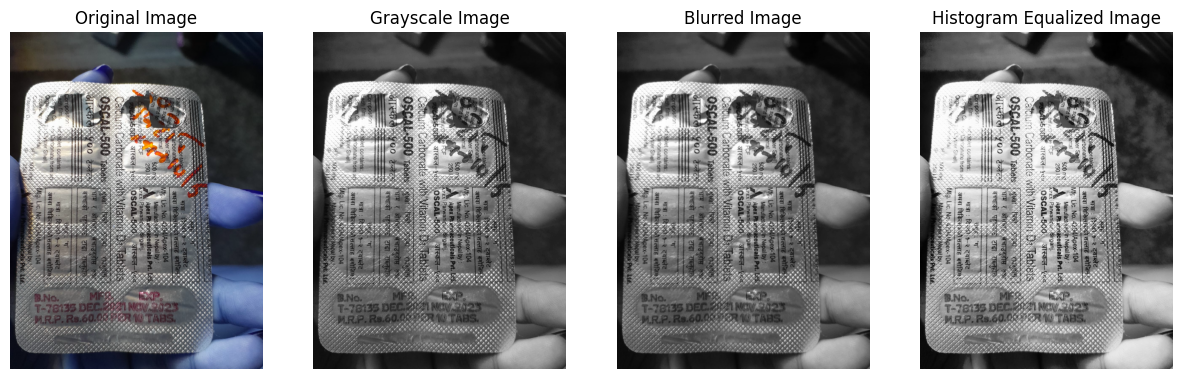

In [92]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR

# Function to plot images
def plot_images(images, titles, cmap=None):
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i], cmap=cmap if cmap else 'gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Load the original image
image_path = '2.jpeg'  # Replace with actual image path if running locally
image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

# Apply histogram equalization to improve contrast
equalized_image = cv2.equalizeHist(gray_image)

# Initialize PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang='en')

# Preprocessing: Use the histogram equalized image for OCR
ocr_result = ocr.ocr(equalized_image)

# Check if OCR results are valid
if ocr_result is None or len(ocr_result) == 0:
    print("No text detected in the image.")
    largest_text = "No text detected"
else:
    # Extract text and find the largest text (medicine name) based on bounding box area
    largest_text = ""
    largest_area = 0

    # Iterate over OCR results to find the largest bounding box (assumed to be the medicine name)
    for line in ocr_result:
        for word in line:
            text = word[1][0]  # Extract the recognized text
            bbox = word[0]  # Get the bounding box coordinates
            
            # Calculate the area of the bounding box
            width = bbox[1][0] - bbox[0][0]
            height = bbox[2][1] - bbox[1][1]
            area = width * height
            
            # Update if this is the largest text detected
            if area > largest_area:
                largest_area = area
                largest_text = text

# Display the recognized largest text (assumed medicine name)
print("Medicine Name (Largest Text):", largest_text)

# Displaying all image versions: original, grayscale, blurred, histogram equalized
images = [image, gray_image, blurred_image, equalized_image]
titles = ['Original Image', 'Grayscale Image', 'Blurred Image', 'Histogram Equalized Image']

# Plot the images
plot_images(images, titles)


LLM

GROQ API

In [83]:
pip install openai

  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached jiter-0.5.0-cp312-none-win_amd64.whl.metadata (3.7 kB)
   ---------------------------------------- 0.0/375.1 kB ? eta -:--:--
   --- ------------------------------------ 30.7/375.1 kB 1.3 MB/s eta 0:00:01
   ------ -------------------------------- 61.4/375.1 kB 812.7 kB/s eta 0:00:01
   ------------- -------------------------- 122.9/375.1 kB 1.0 MB/s eta 0:00:01
   -------------------- ------------------- 194.6/375.1 kB 1.3 MB/s eta 0:00:01
   ---------------------------------- ----- 327.7/375.1 kB 1.6 MB/s eta 0:00:01
   ---------------------------------------- 375.1/375.1 kB 1.7 MB/s eta 0:00:00
Using cached distro-1.9.0-py3-none-any.whl (20 kB)
Using cached jiter-0.5.0-cp312-none-win_amd64.whl (189 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


[2024/09/20 14:01:48] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\Dell/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\Dell/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6,

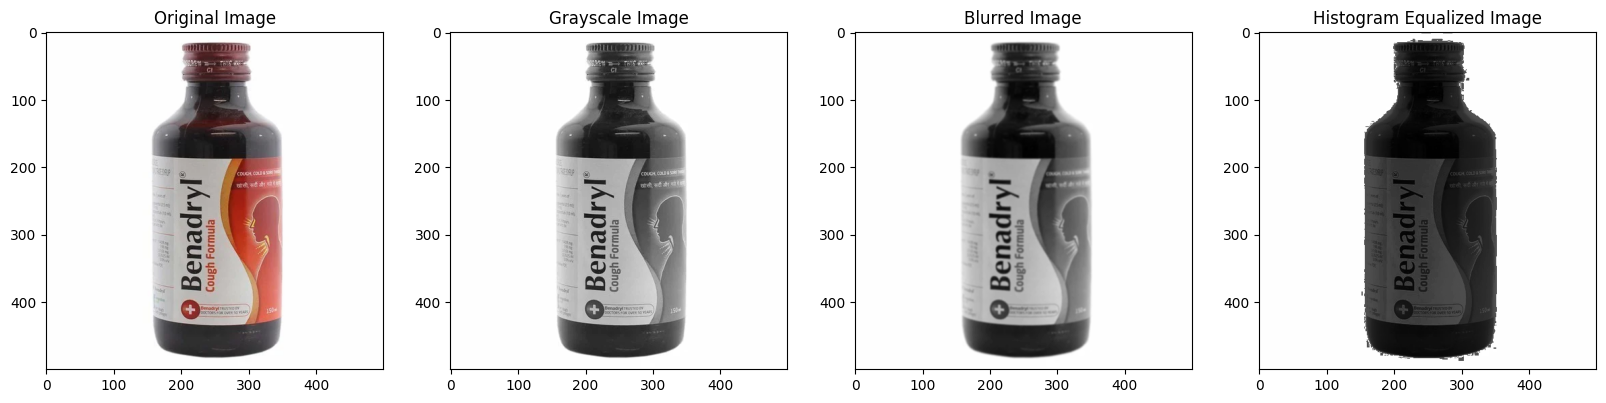

Extracted Medicine Name: Benadryl
Information about Benadryl:
Here is the information about Benadryl (Diphenhydramine):

**Uses:**

1. Allergic reactions: Benadryl is used to treat symptoms of allergic reactions, such as hives, itching, and swelling.
2. Insomnia: Benadryl is sometimes used to help people fall asleep, as it has a sedative effect.
3. Motion sickness: Benadryl can help relieve symptoms of motion sickness, such as nausea and vomiting.

**Precautions:**

1. Avoid using Benadryl if you have a seizure disorder or severe stomach problems.
2. Do not take Benadryl with other medicines that can cause drowsiness, as this can increase the risk of overdose.
3. Be cautious when operating machinery or driving after taking Benadryl, as it can cause dizziness and drowsiness.

**Side Effects:**

1. Drowsiness
2. Dizziness
3. Dry mouth

**Dosage:**

Adults: Take 25-50 mg every 4-6 hours as needed, up to a maximum of 300 mg in 24 hours. Your doctor may adjust the dosage based on your indiv

In [109]:
import cv2
from paddleocr import PaddleOCR
import numpy as np
import matplotlib.pyplot as plt
import requests
import json

# Groq API key
GROQ_API_KEY = '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'

# Function to get medicine info using Groq API
def get_medicine_info(medicine_name):
    url = "https://api.groq.com/openai/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {GROQ_API_KEY}",
        "Content-Type": "application/json"
    }
    data = {
        "model": "llama3-8b-8192",
        "messages": [
            {
                "role": "system",
                "content": "You are a helpful assistant providing concise information about medicines. Provide exactly 3 items for each category if possible. If less than 3 are known, provide as many as you can."
            },
            {
                "role": "user",
                "content": f"""Provide information about the medicine '{medicine_name}' in the following format and in simple language:

Uses:
1. [Use 1]
2. [Use 2]
3. [Use 3]

Precautions:
1. [Precaution 1]
2. [Precaution 2]
3. [Precaution 3]

Side Effects:
1. [Side Effect 1]
2. [Side Effect 2]
3. [Side Effect 3]

Dosage:
[Brief dosage information]

Additional Info:
[Any other crucial information, if applicable]"""
            }
        ],
        "max_tokens": 500
    }

    try:
        response = requests.post(url, headers=headers, data=json.dumps(data))
        response.raise_for_status()
        result = response.json()
        return result['choices'][0]['message']['content']
    except Exception as e:
        return f"Error querying LLM: {e}"

# Initialize the OCR model (English)
ocr = PaddleOCR(use_angle_cls=True, lang='en')

# Function to perform OCR and get the largest text (medicine name)
def extract_medicine_name(image_path):
    image = cv2.imread(image_path)
    
    # Preprocess the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    equalized = cv2.equalizeHist(gray)
    
    # Perform OCR on the preprocessed images
    ocr_result = ocr.ocr(image)
    
    # Initialize variables to store the largest bounding box (assuming it's the medicine name)
    largest_text = ""
    largest_area = 0
    
    # Iterate over OCR results to find the largest bounding box (assumed to be the medicine name)
    for line in ocr_result:
        for word in line:
            text = word[1][0]  # Extract the recognized text
            bbox = word[0]  # Get the bounding box coordinates
            # Calculate area of the bounding box
            area = (bbox[2][0] - bbox[0][0]) * (bbox[2][1] - bbox[0][1])
            
            # Update if this is the largest text detected
            if area > largest_area:
                largest_area = area
                largest_text = text

    # Show preprocessed images and original image (optional visualization)
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[1].imshow(gray, cmap='gray')
    axes[1].set_title('Grayscale Image')
    axes[2].imshow(blurred, cmap='gray')
    axes[2].set_title('Blurred Image')
    axes[3].imshow(equalized, cmap='gray')
    axes[3].set_title('Histogram Equalized Image')
    plt.show()
    
    return largest_text

# Main workflow
def main(image_path):
    # Step 1: Extract medicine name from the image
    medicine_name = extract_medicine_name(image_path)
    
    if medicine_name:
        print(f"Extracted Medicine Name: {medicine_name}")
        
        # Step 2: Query Groq LLM for the medicine information
        medicine_info = get_medicine_info(medicine_name)
        
        # Step 3: Output the medicine info
        print(f"Information about {medicine_name}:\n{medicine_info}")
    else:
        print("Medicine name could not be extracted.")

# Path to the image file
image_path = r'C:\Users\Dell\MedicineOCR\s.webp'

# Run the main workflow
if __name__ == "__main__":
    main(image_path)

TRY TRY TRY

In [107]:
import cv2
from paddleocr import PaddleOCR
import re
import requests
import json

# Groq API key
GROQ_API_KEY = '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'

# Function to get medicine info using Groq API
def get_medicine_info(medicine_name):
    url = "https://api.groq.com/openai/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {GROQ_API_KEY}",
        "Content-Type": "application/json"
    }
    data = {
        "model": "llama3-8b-8192",
        "messages": [
            {
                "role": "system",
                "content": "You are a helpful assistant providing concise information about medicines. Provide exactly 3 items for each category if possible. If less than 3 are known, provide as many as you can."
            },
            {
                "role": "user",
                "content": f"""Provide information about the medicine '{medicine_name}' in the following format:

Uses:
1. [Use 1]
2. [Use 2]
3. [Use 3]

Precautions:
1. [Precaution 1]
2. [Precaution 2]
3. [Precaution 3]

Side Effects:
1. [Side Effect 1]
2. [Side Effect 2]
3. [Side Effect 3]

Dosage:
[Brief dosage information]

Additional Info:
[Any other crucial information, if applicable]"""
            }
        ],
        "max_tokens": 500
    }

    try:
        response = requests.post(url, headers=headers, data=json.dumps(data))
        response.raise_for_status()
        result = response.json()
        return result['choices'][0]['message']['content']
    except Exception as e:
        return f"Error querying LLM: {e}"

# Initialize PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang='en', drop_score=0.5)

# Function to perform OCR and extract a concise medicine name
def extract_medicine_name(image_path):
    image = cv2.imread(image_path)
    
    # Preprocess the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    equalized = cv2.equalizeHist(blurred)
    
    # Perform OCR on the preprocessed image
    ocr_result = ocr.ocr(equalized)
    
    # Combine and filter recognized text
    combined_text = ""
    for line in ocr_result:
        for word in line:
            text = word[1][0]  # Extract the recognized text
            combined_text += text + " "  # Concatenate all recognized words
    
    # Simplified filtering of text to reduce noise
    filtered_text = re.sub(r'[^A-Za-z0-9\s]+', '', combined_text).strip()  # Keep only alphanumeric characters and spaces

    # Limit the length and pick relevant segments
    medicine_name_parts = filtered_text.split()
    if len(medicine_name_parts) > 5:
        medicine_name = " ".join(medicine_name_parts[:5])  # Keep the first 5 words
    else:
        medicine_name = filtered_text

    return medicine_name if medicine_name else "Unknown Medicine Name"

# Main workflow
def main(image_path):
    # Step 1: Extract medicine name from the image
    medicine_name = extract_medicine_name(image_path)
    
    if medicine_name != "Unknown Medicine Name":
        print(f"Extracted Medicine Name: {medicine_name}")
        
        # Step 2: Query Groq LLM for the medicine information
        medicine_info = get_medicine_info(medicine_name)
        
        # Step 3: Output the medicine info
        print(f"Information about {medicine_name}:\n{medicine_info}")
    else:
        print("Medicine name could not be extracted.")

# Path to the image file
image_path = r'C:\Users\Dell\MedicineOCR\2.jpeg'

# Run the main workflow
if __name__ == "__main__":
    main(image_path)


[2024/09/20 14:00:19] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\Dell/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\Dell/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6,

[2024/09/20 14:00:21] ppocr DEBUG: dt_boxes num : 62, elapsed : 0.18157172203063965
[2024/09/20 14:00:21] ppocr DEBUG: cls num  : 62, elapsed : 0.1663360595703125
[2024/09/20 14:00:23] ppocr DEBUG: rec_res num  : 62, elapsed : 1.8874890804290771
Extracted Medicine Name: Organ Compositi Caicium ach fiim
Information about Organ Compositi Caicium ach fiim:
I apologize, but I couldn't find any information on "Organ Compositi Caicium ach fiim".


In [ ]:
model="llama3-8b-8192"